### SET PARAMETERS

In [2]:
from pathlib import Path

# DATA SETTINGS
TRAIN_PATH = Path('data/vids/split/train')
TEST_PATH = Path('data/vids/split/test')
IMG_SIZE = 256

# IF USING FrameGenerator
FRAMES_PER_VIDEO = 100

# IF USING SamplingFrameGenerator
SAMPLES_PER_VIDEO = 10
FRAMES_PER_SAMPLE = 10

# TRAINING SETTINGS
EPOCHS = 10
BATCH_SIZE = 2

### LOAD DATA (Sampling Frame Generator)

In [2]:
import tensorflow as tf
from src.datagen import SamplingFrameGenerator

# CREATE TRAINING/TEST DATASETS

train_generator = SamplingFrameGenerator(TRAIN_PATH, SAMPLES_PER_VIDEO, FRAMES_PER_SAMPLE, (IMG_SIZE, IMG_SIZE), training=True)
test_generator = SamplingFrameGenerator(TEST_PATH, SAMPLES_PER_VIDEO, FRAMES_PER_SAMPLE, (IMG_SIZE, IMG_SIZE), training=False)
output_signature = (tf.TensorSpec(shape = (SAMPLES_PER_VIDEO * FRAMES_PER_SAMPLE, 256, 256, 3), dtype = tf.float32), tf.TensorSpec(shape = (1), dtype = tf.int16))


train_ds = tf.data.Dataset.from_generator(train_generator,output_signature = output_signature)

test_ds = tf.data.Dataset.from_generator(test_generator,output_signature = output_signature)

# ADD BATCH DIMENSION
train_ds = train_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# VERIFY DATA HAS CORRECT SHAPE
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Detected Labels:  {'fake': 0, 'real': 1}
Detected Labels:  {'fake': 0, 'real': 1}
Shape of training set of frames: (2, 100, 256, 256, 3)
Shape of training labels: (2, 1)
Shape of validation set of frames: (2, 100, 256, 256, 3)
Shape of validation labels: (2, 1)


### INITIALIZE/TRAIN (RNN Model - Sampling Frame Generator)

In [3]:
from src.helpers import save_history
from custom_RNN_model import get_cnn_rnn_hybrid
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from time import perf_counter

# LOAD NEW MODEL
model = get_cnn_rnn_hybrid()

# VERIFY MODEL
model.summary()

MODEL_NAME = "RNN_SampleFrame_RegularMeso"


# INITIALIZE OPTIMIZER
optimizer = Adam()

start = perf_counter()

# COMPILE MODEL FOR TRAINING
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Saves the model whenever a new max val accuracy is reached
model_checkpoint_callback = ModelCheckpoint(
    filepath=f"saved_models/{MODEL_NAME}.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# TRAIN
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_ds,
    shuffle=True,
    callbacks=[model_checkpoint_callback]
)

print(f"TOTAL TRAIN TIME: {perf_counter() - start}")

# SAVE HISTORY TO FILE
save_history(history, MODEL_NAME)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,073 (109.66 KB)

 Trainable params: 27,977 (109.29 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10


### VISUALIZE TRAINING HISTORY

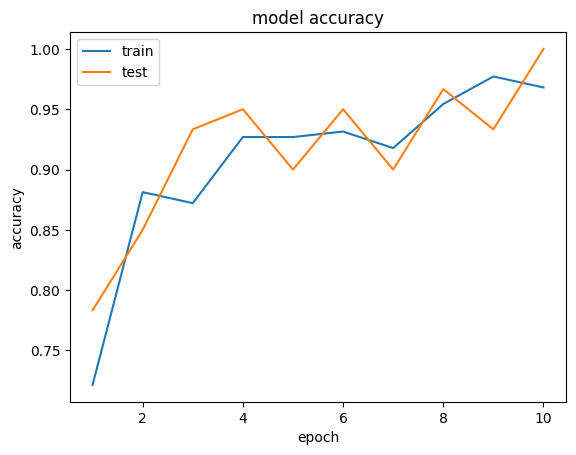

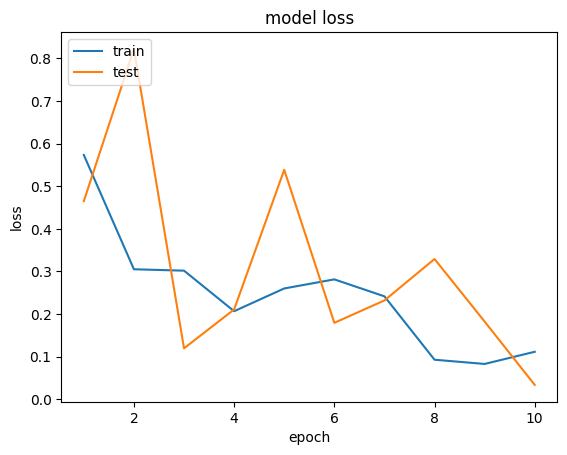

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as matplotlib

# PLOT ACCURACY
plt.plot(range(1, EPOCHS + 1), history.history['accuracy'])
plt.plot(range(1, EPOCHS + 1, 1),history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# PLOT LOSS
plt.plot(range(1, EPOCHS + 1),history.history['loss'])
plt.plot(range(1, EPOCHS + 1),history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### LOAD DATA (Regular Frame Generator)

In [ ]:
import tensorflow as tf
from src.datagen import FrameGenerator

# CREATE TRAINING/TEST DATASETS

train_generator = FrameGenerator(TRAIN_PATH, FRAMES_PER_VIDEO, (IMG_SIZE, IMG_SIZE), training=True)
test_generator = FrameGenerator(TEST_PATH, FRAMES_PER_VIDEO, (IMG_SIZE, IMG_SIZE), training=False)
output_signature = (tf.TensorSpec(shape = (FRAMES_PER_VIDEO, 256, 256, 3), dtype = tf.float32), tf.TensorSpec(shape = (1), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(train_generator,output_signature = output_signature)

test_ds = tf.data.Dataset.from_generator(test_generator,output_signature = output_signature)

# ADD BATCH DIMENSION
train_ds = train_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# VERIFY DATA HAS CORRECT SHAPE
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Detected Labels:  {'fake': 0, 'real': 1}
Detected Labels:  {'fake': 0, 'real': 1}
Shape of training set of frames: (2, 100, 256, 256, 3)
Shape of training labels: (2, 1)
Shape of validation set of frames: (2, 100, 256, 256, 3)
Shape of validation labels: (2, 1)


### INITIALIZE/TRAIN (RNN Model - Regular Frame Generator)

In [ ]:
from src.helpers import save_history
from custom_RNN_model import get_cnn_rnn_hybrid
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from time import perf_counter

# LOAD NEW MODEL
model = get_cnn_rnn_hybrid()

# VERIFY MODEL
model.summary()

MODEL_NAME = "RNN_GeneralFrame_RegularMeso"


# INITIALIZE OPTIMIZER
optimizer = Adam()

start = perf_counter()

# COMPILE MODEL FOR TRAINING
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Saves the model whenever a new max val accuracy is reached
model_checkpoint_callback = ModelCheckpoint(
    filepath=f"saved_models/{MODEL_NAME}.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# TRAIN
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_ds,
    shuffle=True,
    callbacks=[model_checkpoint_callback]
)

print(f"TOTAL TRAIN TIME: {perf_counter() - start}")

# SAVE HISTORY TO FILE
save_history(history, MODEL_NAME)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,073 (109.66 KB)

 Trainable params: 27,977 (109.29 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 769s 6s/step - accuracy: 0.6507 - loss: 0.6541 - val_accuracy: 0.8167 - val_loss: 0.3459
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 656s 6s/step - accuracy: 0.8584 - loss: 0.3059 - val_accuracy: 0.7167 - val_loss: 0.6732
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 734s 7s/step - accuracy: 0.9207 - loss: 0.2805 - val_accuracy: 0.8833 - val_loss: 0.3438
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 743s 7s/step - accuracy: 0.9069 - loss: 0.2357 - val_accuracy: 0.8000 - val_loss: 0.5631
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 771s 7s/step - accuracy: 0.9209 - loss: 0.2194 - val_accuracy: 0.9000 - val_loss: 0.2738
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 987s 9s/step - accuracy: 0.9082 - loss: 0.2351 - val_accuracy: 0.8500 - val_loss: 0.2716
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 968s 9s/step - accuracy: 0.9131 - loss: 0.2555 - val_accuracy: 0.8833 - val_loss: 0.3439
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 940s 9s/step - accuracy: 0.8221 - loss: 0.3957 - val_accu

### VISUALIZE TRAINING HISTORY

In [3]:
import matplotlib.pyplot as plt
import matplotlib as matplotlib

# PLOT ACCURACY
plt.plot(range(1, EPOCHS + 1), history.history['accuracy'])
plt.plot(range(1, EPOCHS + 1, 1),history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# PLOT LOSS
plt.plot(range(1, EPOCHS + 1),history.history['loss'])
plt.plot(range(1, EPOCHS + 1),history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined